In [ ]:
import os
import torch
from ultralytics import YOLO
import mlflow

In [2]:
import os
from roboflow import Roboflow
import mlflow

# --- Configuration ---
# 1. Base Directory Setup
# Define absolute paths based on the current working directory
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data", "base_dataset")
MLRUNS_DIR = os.path.join(BASE_DIR, "mlruns")

# Ensure data directory exists
os.makedirs(DATA_DIR, exist_ok=True)

print("Initializing Roboflow connection for dataset verification...")

# Preserve current working directory to restore it later
cwd_original = os.getcwd()

try:
    # Change context to data directory for download
    os.chdir(DATA_DIR)
    
    # 2. Connection and Download
    # Note: Ideally, API keys should be loaded from environment variables for security
    rf = Roboflow(api_key="bio3BpUDOCkind2bO9vy")
    project = rf.workspace("living-room").project("living-room-hn7cw")
    version = project.version(9)
    
    # Download dataset (or validate if already exists) using YOLOv8 format
    dataset = version.download("yolov8")
    
    # Capture the exact path provided by Roboflow
    DATASET_YAML = os.path.join(dataset.location, "data.yaml")
    
    # Sanitize output: Print relative path instead of absolute system path
    rel_path = os.path.relpath(DATASET_YAML, BASE_DIR)
    print(f"Dataset configuration found at: {rel_path}")

except Exception as e:
    print(f"Critical error retrieving dataset: {e}")
    DATASET_YAML = None
    raise e # Re-raise exception to stop execution if data is missing

finally:
    # Restore original working directory
    os.chdir(cwd_original)

# 3. MLflow Configuration
mlflow.set_tracking_uri(f"file:///{MLRUNS_DIR}")
mlflow.set_experiment("Living_Room_Furniture_V1")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Initializing Roboflow connection for dataset verification...
loading Roboflow workspace...
loading Roboflow project...
Dataset configuration found at: data\base_dataset\Living-Room-9\data.yaml


The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.


<Experiment: artifact_location=('file:///c:\\Users\\andre\\OneDrive\\Documents\\UPS\\Inteligencia '
 'Artificial\\YOLOv8_living-room_furniture\\mlruns/962311314158374486'), creation_time=1769708524062, experiment_id='962311314158374486', last_update_time=1769708524062, lifecycle_stage='active', name='Living_Room_Furniture_V1', tags={}>

In [ ]:
def entrenar():
    import torch
    import gc
    import shutil
    import os
    from ultralytics import YOLO
    
    # 1. Memory Cleanup
    gc.collect()
    torch.cuda.empty_cache() 

    # 2. Check for existing model
    BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
    DEST_MODEL_PATH = os.path.join(BASE_DIR, "models", "best.pt")

    if os.path.exists(DEST_MODEL_PATH):
        rel_path = os.path.relpath(DEST_MODEL_PATH, BASE_DIR)
        print(f"Existing model found at: {rel_path}")
        print("Skipping training session.")
        print("-" * 60)
        print("Running validation on existing model to display metrics:")
        
        try:
            existing_model = YOLO(DEST_MODEL_PATH)
            # Run validation directly (Standard output will show absolute paths)
            existing_model.val(data=DATASET_YAML, verbose=True)
                
        except Exception as e:
            print(f"Error validating existing model: {e}")
            
        return

    # 3. Device Configuration
    if torch.cuda.is_available():
        DEVICE = 0
        print(f"GPU Detected: {torch.cuda.get_device_name(0)}")
    else:
        DEVICE = 'cpu'
        print("GPU not detected. Using CPU.")

    # 4. Model Initialization
    model = YOLO('yolov8m.pt')
    
    print("Initiating training process...")
    
    mlflow.autolog()
    
    # 5. Training Execution
    results = model.train(
        data=DATASET_YAML,
        epochs=50,
        imgsz=480,
        
        batch=4,          
        workers=2, 
        
        device=DEVICE,
        name='yolov8m_balanced_v1', 
        project=os.path.join(BASE_DIR, "models_history"),
        exist_ok=True,
        plots=True,
        
        # Data Augmentation parameters
        fliplr=0.5,      
        mosaic=1.0,      
        hsv_v=0.4,       
        hsv_s=0.7,      
        degrees=10.0,    
        translate=0.1,   
        scale=0.5,      
    )
    
    # 6. Model Export
    source_weights = str(results.save_dir) + "/weights/best.pt"
    
    os.makedirs(os.path.dirname(DEST_MODEL_PATH), exist_ok=True)
    
    if os.path.exists(source_weights):
        shutil.copy(source_weights, DEST_MODEL_PATH)
        print(f"Model successfully exported to: {os.path.relpath(DEST_MODEL_PATH, BASE_DIR)}")
    else:
        print("Error: Training weights file not found.")

if __name__ == "__main__":
    entrenar()

Existing model found at: models\best.pt
Skipping training session.
------------------------------------------------------------
Running validation on existing model to display metrics:
Ultralytics 8.4.8  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 93 layers, 25,851,340 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 753.8369.2 MB/s, size: 110.1 KB)
val: Scanning C:\Users\andre\OneDrive\Documents\UPS\Inteligencia Artificial\YOLOv8_living-room_furniture\data\base_dataset\Living-Room-9\valid\labels.cache... 149 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 149/149  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.2it/s 3.1s.3ss
                   all        149       1905      0.767      0.748      0.791      0.598
          Accent Chair        100        139      0.913      0.911      0.936      0.812
     Artif

Running validation to generate evaluation plots...
Ultralytics 8.4.8  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 93 layers, 25,851,340 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 539.9397.8 MB/s, size: 60.9 KB)
val: Scanning C:\Users\andre\OneDrive\Documents\UPS\Inteligencia Artificial\YOLOv8_living-room_furniture\data\base_dataset\Living-Room-9\valid\labels.cache... 149 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 149/149  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.3it/s 3.0s.3ss
                   all        149       1905      0.767      0.748      0.791      0.598
          Accent Chair        100        139      0.913      0.911      0.936      0.812
     Artificial Plants         68         87       0.56      0.621      0.578      0.337
           Chandeliers         17         23      0.773 

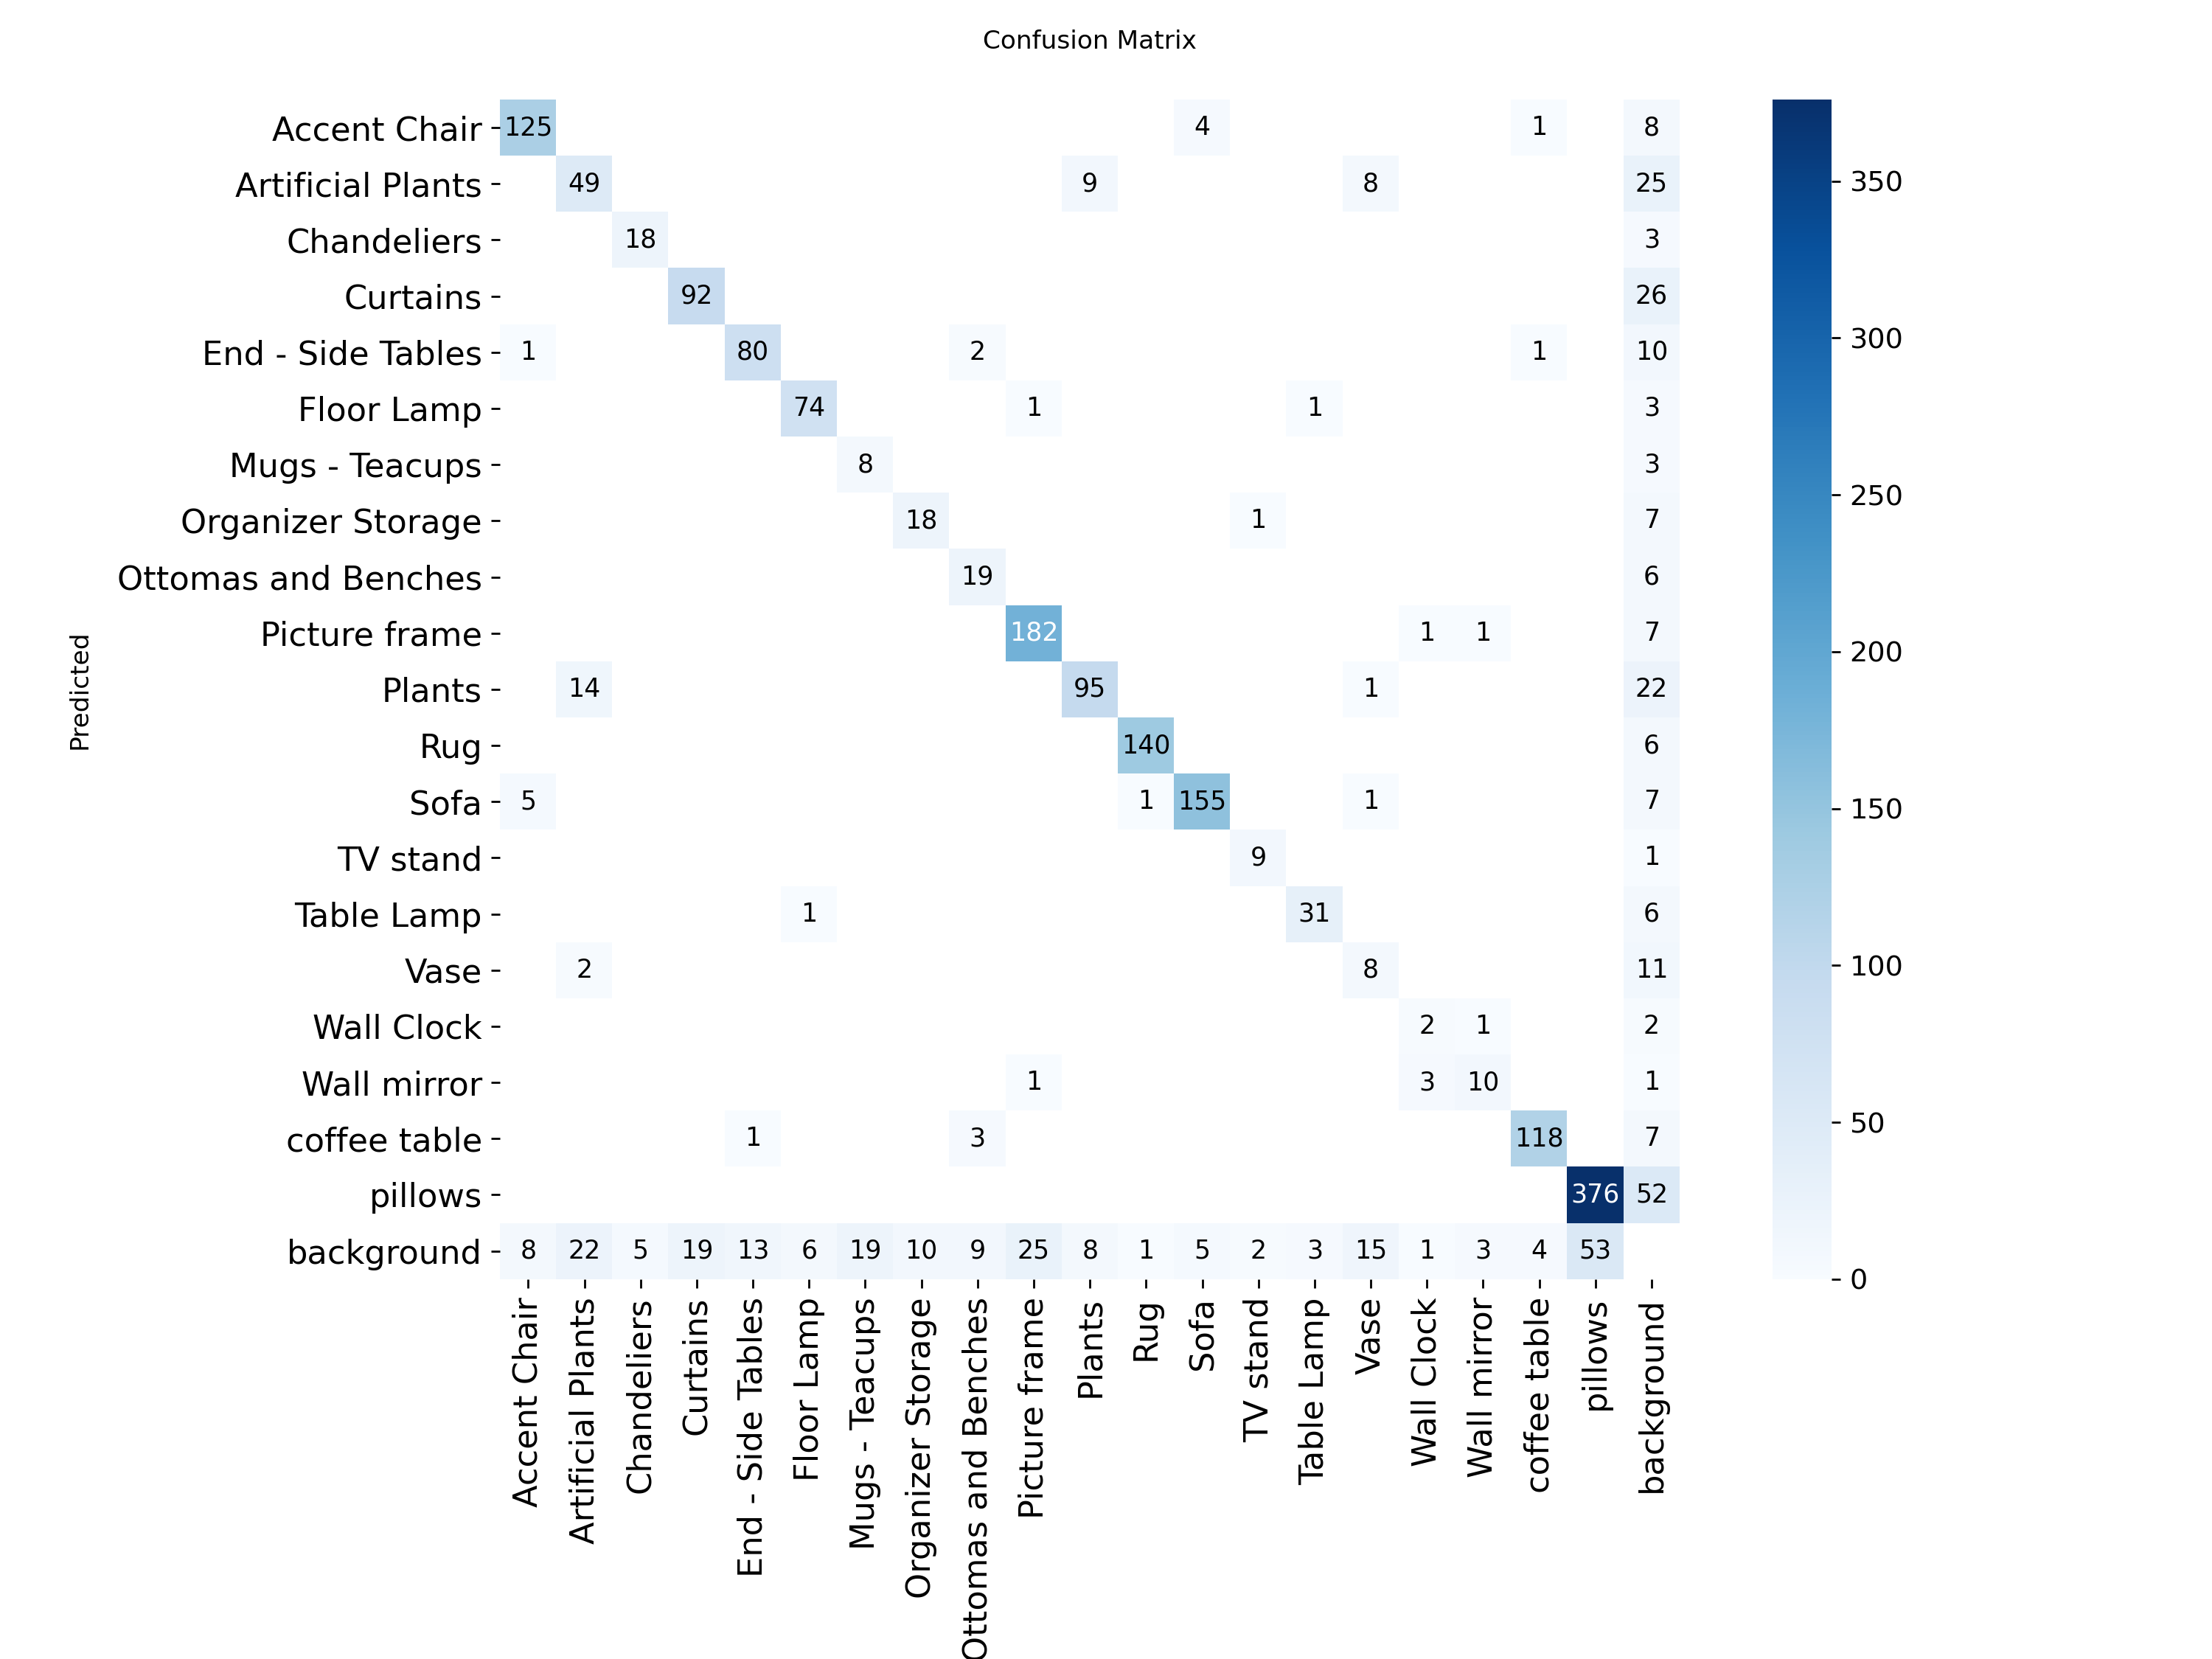

In [3]:
import os
from ultralytics import YOLO
from IPython.display import Image, display

# --- Configuration ---
# Define base paths using absolute positioning
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
MODEL_PATH = os.path.join(BASE_DIR, "models", "best.pt")

# --- Execution ---
if os.path.exists(MODEL_PATH):
    # 1. Load the trained model
    model = YOLO(MODEL_PATH)

    print("Running validation to generate evaluation plots...")
    
    # 2. Run Validation
    # plots=True is required to generate the confusion matrix image file
    metrics = model.val(plots=True)

    # 3. Display Confusion Matrix
    print("\n" + "-"*50)
    print("CONFUSION MATRIX VISUALIZATION")
    print("-"*50)

    # Locate the image generated by YOLO
    save_dir = metrics.save_dir
    path_matrix = os.path.join(save_dir, "confusion_matrix.png")

    if os.path.exists(path_matrix):
        display(Image(filename=path_matrix, width=800))
    else:
        # Fallback for normalized version if simple version doesn't exist
        path_norm = os.path.join(save_dir, "confusion_matrix_normalized.png")
        if os.path.exists(path_norm):
            display(Image(filename=path_norm, width=800))
        else:
            print(f"Warning: Confusion matrix image not found in: {save_dir}")

else:
    print(f"Error: Model file not found at {MODEL_PATH}")